In [1]:
# import inportant libraries 
# import data
# importting Libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr

In [10]:
df = pd.read_csv('../data/dataset.csv', low_memory=False)


In [11]:

# Get basic information about the dataset
print("basic information about the dataset")
print(df.info())

# Summarize the numerical columns
print("Summarize the numerical columns")
numerical_columns = ['TotalPremium', 'TotalClaims']
print(df[numerical_columns].describe())
print(" missing values")
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)


basic information about the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             5631 non-null     object 
 11  Gender                    49572 non-null    object 
 12  Country                   1000098 non-null  obje

In [13]:
# Dropping columns with more than 80% missing data
threshold = 0.8
df_cleaned = df.dropna(thresh=int(threshold * len(df)), axis=1)

# Impute numerical columns with median
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
df_cleaned.loc[:, numerical_cols] = df_cleaned.loc[:, numerical_cols].fillna(df_cleaned[numerical_cols].median())

# Impute categorical columns with mode
categorical_cols = df_cleaned.select_dtypes(include=['object', 'bool']).columns
df_cleaned.loc[:, categorical_cols] = df_cleaned.loc[:, categorical_cols].fillna(df_cleaned[categorical_cols].mode().iloc[0])

# Display the remaining missing values
missing_values = df_cleaned.isnull().sum()
print(missing_values[missing_values > 0])


Series([], dtype: int64)


In [15]:
# Creating the Claims-to-Premium ratio
df_cleaned.loc[:, 'ClaimsToPremiumRatio'] = df_cleaned['TotalClaims'] / (df_cleaned['TotalPremium'] + 1e-5)

# Extracting the month from the TransactionMonth column
df_cleaned.loc[:, 'TransactionMonth'] = pd.to_datetime(df_cleaned['TransactionMonth'], errors='coerce')
df_cleaned.loc[:, 'TransactionMonthNum'] = df_cleaned['TransactionMonth'].dt.month

# Displaying the first few rows to verify the new features
df_cleaned[['TotalClaims', 'TotalPremium', 'ClaimsToPremiumRatio', 'TransactionMonthNum']].head()


TotalClaims  TotalPremium  ClaimsToPremiumRatio  TransactionMonthNum
0          0.0     21.929825                   0.0                    3
1          0.0     21.929825                   0.0                    5
2          0.0      0.000000                   0.0                    7
3          0.0    512.848070                   0.0                    5
4          0.0      0.000000                   0.0                    7

In [16]:
# One-hot encoding for categorical columns
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

# Display the shape of the dataframe after encoding
print(f"Dataframe shape after encoding: {df_encoded.shape}")

# Display the first few rows to verify the encoding
df_encoded.head()


Dataframe shape after encoding: (1000098, 1275)


UnderwrittenCoverID  PolicyID  PostalCode  RegistrationYear  Cylinders  \
0               145249     12827        1459              2004        6.0   
1               145249     12827        1459              2004        6.0   
2               145249     12827        1459              2004        6.0   
3               145255     12827        1459              2004        6.0   
4               145255     12827        1459              2004        6.0   

   cubiccapacity  kilowatts  NumberOfDoors  CapitalOutstanding  SumInsured  \
0         2597.0      130.0            4.0           11.689405        0.01   
1         2597.0      130.0            4.0           11.689405        0.01   
2         2597.0      130.0            4.0           11.689405        0.01   
3         2597.0      130.0            4.0           11.689405   119300.00   
4         2597.0      130.0            4.0           11.689405   119300.00   

   ...  CoverGroup_Standalone passenger liability  \
0  ...                                      False   
1  ...                                      False   
2  ...                                      False   
3  ...                                      False   
4  ...                                      False   

   CoverGroup_Third Party Only  CoverGroup_Trailer  \
0                        False               False   
1                        False               False   
2                        False               False   
3                        False               False   
4                        False               False   

   Section_Motor Comprehensive  Section_Optional Extended Covers  \
0                         True                             False   
1                         True                             False   
2                         True                             False   
3                         True                             False   
4                         True                             False   

   Section_Standalone passenger liability  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   Section_Third party or third party, fire and theft only  \
0                                              False         
1                                              False         
2                                              False         
3                                              False         
4                                              False         

   Product_Mobility Commercial Cover: Monthly  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   Product_Mobility Metered Taxis: Monthly  \
0                                     True   
1                                     True   
2                                     True   
3                                     True   
4                                     True   

   Product_Standalone Passenger Liability  
0                                   False  
1                                   False  
2                                   False  
3                                   False  
4                                   False  

[5 rows x 1275 columns]

In [17]:
from sklearn.model_selection import train_test_split

# Define the target variable and features
X = df_encoded.drop(['TotalPremium', 'TotalClaims'], axis=1)  # Features
y = df_encoded['TotalPremium']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (800078, 1273), X_test shape: (200020, 1273)
y_train shape: (800078,), y_test shape: (200020,)


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Linear Regression MSE: {mse}")
print(f"Linear Regression R^2: {r2}")


Linear Regression MSE: 22628.071014168578
Linear Regression R^2: 0.17979108052527837


In [19]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the model
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree Mean Squared Error: {mse_dt}")
print(f"Decision Tree R^2 Score: {r2_dt}")


Decision Tree Mean Squared Error: 2647.387628728728
Decision Tree R^2 Score: 0.9040390608182772


In [20]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")


Random Forest Mean Squared Error: 1884.9892655860967
Random Forest R^2 Score: 0.93167402525033


In [21]:
import xgboost as xgb

# Initialize the model
xgb_model = xgb.XGBRegressor(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Mean Squared Error: {mse_xgb}")
print(f"XGBoost R^2 Score: {r2_xgb}")


XGBoost Mean Squared Error: 7778.054468925078
XGBoost R^2 Score: 0.7180656871910134


                                              Feature  Importance
10                           CalculatedPremiumPerTerm    0.408430
11                               ClaimsToPremiumRatio    0.165430
9                                          SumInsured    0.119590
12                                TransactionMonthNum    0.094786
0                                 UnderwrittenCoverID    0.045888
1                                            PolicyID    0.033790
2                                          PostalCode    0.014001
29               TransactionMonth_2015-03-01 00:00:00    0.012644
25               TransactionMonth_2014-11-01 00:00:00    0.010374
1194  ExcessSelected_Mobility - Metered Taxis - R5000    0.005056


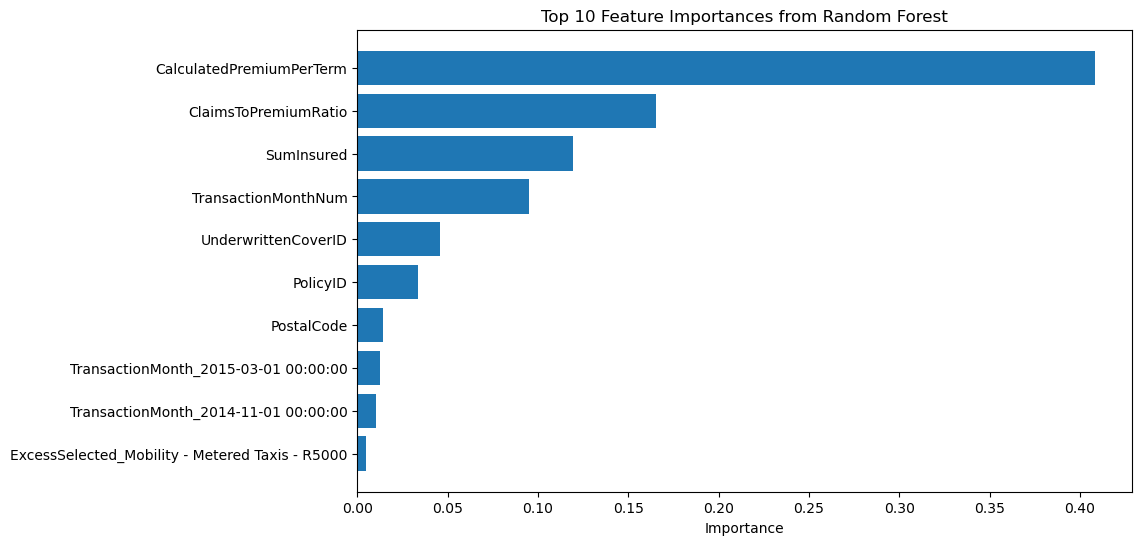

In [22]:
# Get feature importance from the Random Forest model
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances
importance = rf_model.feature_importances_

# Create a DataFrame to hold the feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 important features
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10))
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=1, verbose=2)
grid_search.fit(X_train, y_train)


In [ ]:
import shap

# Create an explainer
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the summary plot for feature importance based on SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
import matplotlib.pyplot as plt

# Model names and their metrics
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
mse_scores = [mse_lr, mse_dt, mse_rf, mse_xgb]
r2_scores = [r2_lr, r2_dt, r2_rf, r2_xgb]

# Plot MSE and R2 scores
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# MSE plot
ax[0].barh(models, mse_scores, color=['blue', 'orange', 'green', 'red'])
ax[0].set_title('Mean Squared Error (MSE)')
ax[0].set_xlabel('MSE')

# R2 Score plot
ax[1].barh(models, r2_scores, color=['blue', 'orange', 'green', 'red'])
ax[1].set_title('R^2 Score')
ax[1].set_xlabel('R^2')

plt.tight_layout()
plt.show()
